<a href="https://colab.research.google.com/github/Nuha4/adelaide_metrocard-cpi-fuel-correlation/blob/main/adl_metrocard_cpi_fuel_correlation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
import numpy as np
import glob
import os

In [ ]:
# Load, Merge and Clean MetroCard Usage Data for Adelaide (2015_Q4 to 2024_Q4)
folder_path = 'data_metro/'
file_pattern = os.path.join(folder_path, "*anded*.csv")
all_files = glob.glob(file_pattern)

# Read and concatenate
df_list = []
for file in all_files:
    df = pd.read_csv(file)
    df['SOURCE_FILE'] = os.path.basename(file)  # Optional: track source file
    df_list.append(df)
combined_metro_df = pd.concat(df_list, ignore_index=True)

print(combined_metro_df)

# # Check unparseable rows
# invalid_dates = combined_metro_df[combined_metro_df['VALIDATION_DATE'].isna()]
# print("Unparseable rows:", len(invalid_dates))
# print(invalid_dates[['SOURCE_FILE', 'VALIDATION_DATE']].head())


# Convert date and prepare monthly data
combined_metro_df['VALIDATION_DATE'] = pd.to_datetime(
    combined_metro_df['VALIDATION_DATE'],
    format='mixed',
    dayfirst=True,
    errors='coerce'
)
# combined_metro_df['VALIDATION_DATE'] = pd.to_datetime(combined_metro_df['VALIDATION_DATE'], dayfirst=True)
combined_metro_df['BAND_BOARDINGS_FLOOR'] = pd.to_numeric(combined_metro_df['BAND_BOARDINGS_FLOOR'], errors='coerce')
combined_metro_df['Month'] = combined_metro_df['VALIDATION_DATE'].dt.to_period('M').dt.to_timestamp()

# Aggregate by month
monthly_metro = combined_metro_df.groupby('Month')['BAND_BOARDINGS_FLOOR'].sum().reset_index()
monthly_metro = monthly_metro.rename(columns={'BAND_BOARDINGS_FLOOR': 'MetroCard_Usage'})

# Save for reuse
monthly_metro.to_csv("combined_metrocard_monthly.csv", index=False)
print(monthly_metro.head())


         VALIDATION_DATE  NUM_MODE_TRANSPORT ROUTE_CODE  ROUTE_DIRECTION  \
0             22/05/2023                   0          0                0   
1             19/06/2023                   0          0                0   
2              2/04/2023                   1     OD1MTB                0   
3              4/05/2023                   1     OD1MTB                0   
4             13/05/2023                   1     OD1MTB                0   
...                  ...                 ...        ...              ...   
59247577      11/04/2024                   1         J1                1   
59247578      11/04/2024                   1         J2                1   
59247579      11/04/2024                   1        M44                1   
59247580      11/04/2024                   1       178M                1   
59247581      11/04/2024                   1        252                1   

           GTFS_ID  MEDIUM_TYPE BAND_BOARDINGS  BAND_BOARDINGS_FLOOR  \
0         10184

In [ ]:
# Drop extra rows after 2024 Q4
monthly_metro = pd.read_csv('combined_metrocard_monthly.csv')
monthly_metro = monthly_metro[monthly_metro['Month'] <= '2024-12-31']
print(monthly_metro.head())
print(monthly_metro.tail())


        Month  MetroCard_Usage
0  2015-10-01          5242675
1  2015-11-01          5127222
2  2015-12-01          4052606
3  2016-01-01          3721365
4  2016-02-01          5220318
          Month  MetroCard_Usage
106  2024-08-01          4347875
107  2024-09-01          4032887
108  2024-10-01          4046780
109  2024-11-01          3901431
110  2024-12-01          3056540


In [ ]:
summary = monthly_metro['MetroCard_Usage'].describe().astype(int).apply(lambda x: f"{x:,}")
print(summary)

count          111
mean     4,173,776
std      1,164,770
min        965,965
25%      3,442,987
50%      4,135,112
75%      5,035,557
max      6,354,670
Name: MetroCard_Usage, dtype: object


In [ ]:
# Load and Clean CPI Data (2015 Q4 to 2024 Q4)
cpi_preview = pd.read_excel("CPI_640103.xlsx", sheet_name='Data1', header=None)
cpi_data = cpi_preview.iloc[10:, [0, 4]].copy()
cpi_data.columns = ['Date', 'CPI_Adelaide']

# Convert to datetime and numeric
cpi_data['Date'] = pd.to_datetime(cpi_data['Date'], errors='coerce')
cpi_data['CPI_Adelaide'] = pd.to_numeric(cpi_data['CPI_Adelaide'], errors='coerce')

# Drop rows with missing dates and Filter
cpi_data = cpi_data[cpi_data['Date'].notna()]
cpi_data = cpi_data[(cpi_data['Date'] >= '2015-07-01') & (cpi_data['Date'] <= '2024-12-31')]

# Interpolate quarterly data to monthly
cpi_monthly = cpi_data.set_index('Date').resample('MS').interpolate(method='linear').reset_index()
cpi_monthly['Month'] = cpi_monthly['Date'].dt.to_period('M').dt.to_timestamp()

In [ ]:
# Drop extra rows before 2015 Q4
cpi_monthly = cpi_monthly[cpi_monthly['Month'] >= '2015-10-01']
print(cpi_monthly.head())
print(cpi_monthly.tail())


        Date  CPI_Adelaide      Month
1 2015-10-01    115.200000 2015-10-01
2 2015-11-01    115.300000 2015-11-01
3 2015-12-01    115.400000 2015-12-01
4 2016-01-01    115.566667 2016-01-01
5 2016-02-01    115.733333 2016-02-01
          Date  CPI_Adelaide      Month
107 2024-08-01    152.833333 2024-08-01
108 2024-09-01    153.400000 2024-09-01
109 2024-10-01    152.600000 2024-10-01
110 2024-11-01    151.800000 2024-11-01
111 2024-12-01    151.000000 2024-12-01


In [ ]:
# Load and filter SA fuel consumption data  (2015_Q4 to 2024_Q4)
fuel_df = pd.read_excel("australian-petroleum-statistics-data-extract-december-2024.xlsx",
                        sheet_name='Sales by state and territory')

fuel_df = fuel_df[(fuel_df['Month'] >= '2015-10-01') & (fuel_df['Month'] <= '2024-12-31')]
fuel_df = fuel_df[fuel_df['State'] == 'SA'].copy()

# Clean and format columns
fuel_df['Month'] = pd.to_datetime(fuel_df['Month'], errors='coerce')
fuel_df['Automotive gasoline: total (ML)'] = fuel_df['Automotive gasoline: total (ML)'].replace('n.p.', np.nan)
fuel_df['Automotive gasoline: total (ML)'] = pd.to_numeric(fuel_df['Automotive gasoline: total (ML)'], errors='coerce')

# Finalize structure
fuel_df = fuel_df[['Month', 'Automotive gasoline: total (ML)']]
fuel_df = fuel_df.rename(columns={'Automotive gasoline: total (ML)': 'Fuel_Consumption_ML'})

print(fuel_df.head())
print(fuel_df.tail())



         Month  Fuel_Consumption_ML
585 2015-10-01                106.2
586 2015-11-01                102.8
587 2015-12-01                115.1
588 2016-01-01                101.0
589 2016-02-01                104.8
         Month  Fuel_Consumption_ML
691 2024-08-01                 89.2
692 2024-09-01                 84.8
693 2024-10-01                 86.7
694 2024-11-01                 88.9
695 2024-12-01                 85.9


In [ ]:
cpi_monthly['Month'] = pd.to_datetime(cpi_monthly['Month'])
fuel_df['Month'] = pd.to_datetime(fuel_df['Month'])
monthly_metro['Month'] = pd.to_datetime(monthly_metro['Month'])

# Merge All Datasets
combined_df = pd.merge(cpi_monthly[['Month', 'CPI_Adelaide']], fuel_df, on='Month', how='outer')
combined_df = pd.merge(combined_df, monthly_metro, on='Month', how='outer')
combined_df = combined_df.sort_values('Month').reset_index(drop=True)

# Save for resue
combined_df.to_csv("metrocard_cpi_fuel_combined.csv", index=False)
print(combined_df.head())
print(combined_df.tail())

       Month  CPI_Adelaide  Fuel_Consumption_ML  MetroCard_Usage
0 2015-10-01        115.20               106.20          5242675
1 2015-11-01        115.30               102.80          5127222
2 2015-12-01        115.40               115.10          4052606
3 2016-01-01        115.57               101.00          3721365
4 2016-02-01        115.73               104.80          5220318
         Month  CPI_Adelaide  Fuel_Consumption_ML  MetroCard_Usage
106 2024-08-01        152.83                89.20          4347875
107 2024-09-01        153.40                84.80          4032887
108 2024-10-01        152.60                86.70          4046780
109 2024-11-01        151.80                88.90          3901431
110 2024-12-01        151.00                85.90          3056540


In [21]:
df = pd.read_csv('metrocard_cpi_fuel_combined.csv')
print(df.head())

# Data Quality Check
print(df.dtypes)                # Check column data types
print(df.isna().sum())         # Count missing values
missing_rows = df[df.isna().any(axis=1)]
print(missing_rows)                     # Show rows with missing values
print(df.duplicated().sum())   # Count duplicate rows
print(df['Month'].min(), df['Month'].max())  # Check date range

# Format numbers and show summary stats
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df.describe(include='number')

        Month  CPI_Adelaide  Fuel_Consumption_ML  MetroCard_Usage
0  2015-10-01        115.20               106.20          5242675
1  2015-11-01        115.30               102.80          5127222
2  2015-12-01        115.40               115.10          4052606
3  2016-01-01        115.57               101.00          3721365
4  2016-02-01        115.73               104.80          5220318
Month                   object
CPI_Adelaide           float64
Fuel_Consumption_ML    float64
MetroCard_Usage          int64
dtype: object
Month                  0
CPI_Adelaide           0
Fuel_Consumption_ML    0
MetroCard_Usage        0
dtype: int64
Empty DataFrame
Columns: [Month, CPI_Adelaide, Fuel_Consumption_ML, MetroCard_Usage]
Index: []
0
2015-10-01 2024-12-01


,CPI_Adelaide,Fuel_Consumption_ML,MetroCard_Usage
count,111.00,111.00,111.00
mean,129.73,94.72,4173776.55
std,11.21,9.30,1164770.08
min,115.20,60.80,965965.00
25%,123.72,87.55,3442987.50
50%,125.93,94.60,4135112.00
75%,137.37,102.05,5035557.50
max,153.40,115.10,6354670.00


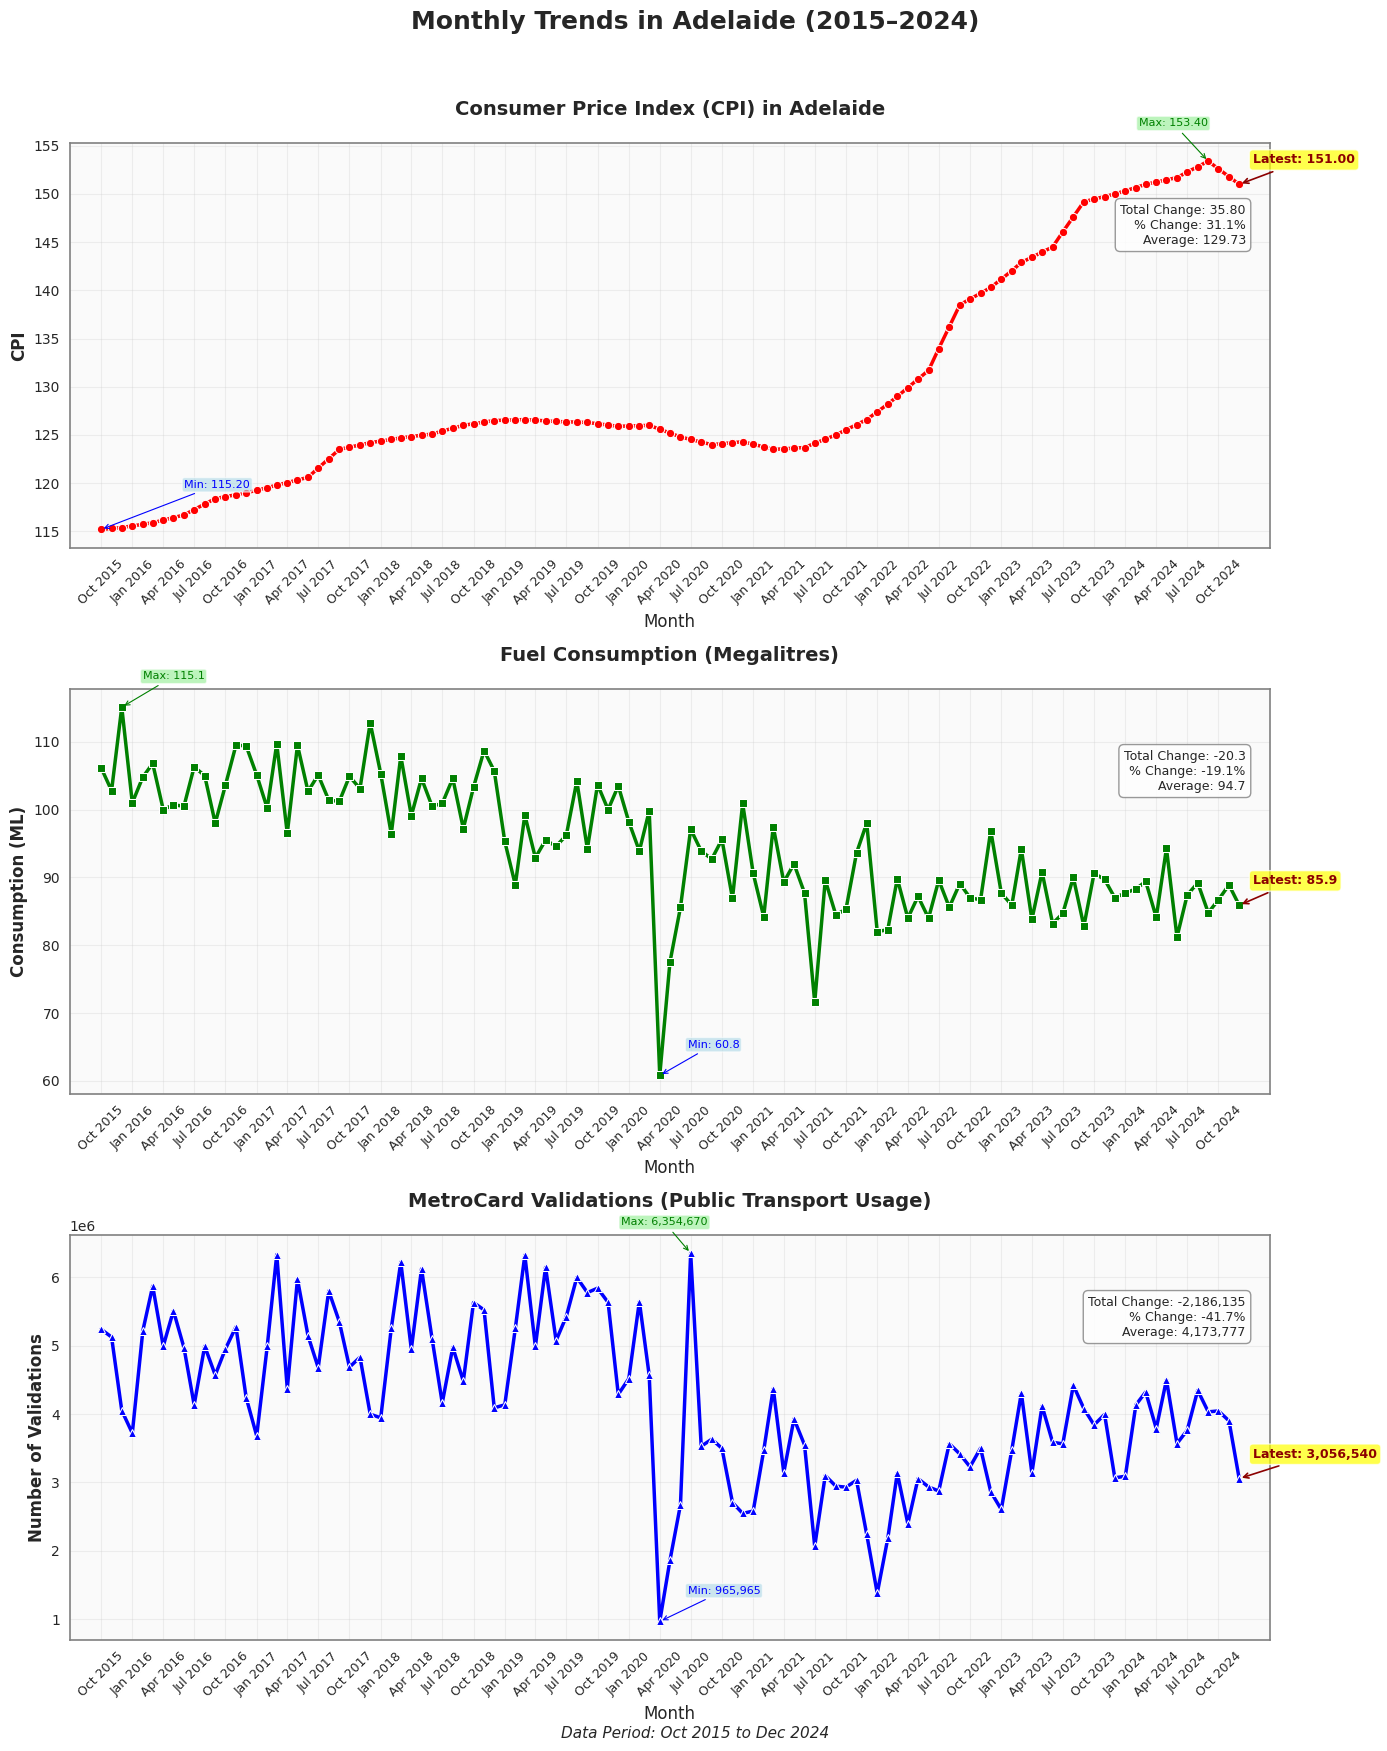

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Set a nice style for the plots
sns.set_style("whitegrid")
fig, axes = plt.subplots(3, 1, figsize=(14, 18))
fig.suptitle('Monthly Trends in Adelaide (2015–2024)', fontsize=18, fontweight='bold')

# Create proper datetime index based on your data period (2015-2024)
def create_datetime_index(df, start_year=2015, start_month=1):
    """Create a proper datetime index for the DataFrame"""
    num_months = len(df)
    date_range = pd.date_range(
        start=f'{start_year}-{start_month:02d}-01',
        periods=num_months,
        freq='MS'  # Month Start frequency
    )
    return date_range


df_with_dates = df.copy()
df_with_dates.index = pd.to_datetime(df_with_dates['Month'])

# Helper function to annotate points with better positioning
def annotate_points(ax, x_data, y, label_fmt="{:.2f}", show_all=False, show_minmax=True, show_last=True):
    """
    Annotation function with better positioning to avoid overlaps
    """
    if len(x_data) == 0:
        return

    # Annotate last point
    if show_last:
        ax.annotate(f'Latest: {label_fmt.format(y.iloc[-1])}',
                    xy=(x_data[-1], y.iloc[-1]),
                    xytext=(10, 15),
                    textcoords='offset points',
                    fontsize=9,
                    fontweight='bold',
                    color='darkred',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor='yellow', alpha=0.7),
                    arrowprops=dict(arrowstyle='->', lw=1.2, color='darkred'))

    # Annotate min and max points with better positioning
    if show_minmax and len(y) > 1:
        min_idx = y.argmin()  # Position in array
        max_idx = y.argmax()  # Position in array

        min_x_pos = x_data[min_idx]
        max_x_pos = x_data[max_idx]
        min_y_val = y.iloc[min_idx]
        max_y_val = y.iloc[max_idx]

        # Smart positioning to avoid overlaps
        if min_idx < len(x_data) * 0.1:
            min_offset_x = 60
            min_offset_y = 30
        else:
            min_offset_x = 20
            min_offset_y = -30 if min_y_val > y.mean() else 20

        ax.annotate(f'Min: {label_fmt.format(min_y_val)}',
                    xy=(min_x_pos, min_y_val),
                    xytext=(min_offset_x, min_offset_y),
                    textcoords='offset points',
                    fontsize=8,
                    color='blue',
                    bbox=dict(boxstyle="round,pad=0.2", facecolor='lightblue', alpha=0.6),
                    arrowprops=dict(arrowstyle='->', lw=0.8, color='blue'))

        # Max point - position based on location in plot
        max_offset_y = 25 if max_idx > len(x_data) * 0.7 else 20
        max_offset_x = -50 if max_idx > len(x_data) * 0.5 else 15

        ax.annotate(f'Max: {label_fmt.format(max_y_val)}',
                    xy=(max_x_pos, max_y_val),
                    xytext=(max_offset_x, max_offset_y),
                    textcoords='offset points',
                    fontsize=8,
                    color='green',
                    bbox=dict(boxstyle="round,pad=0.2", facecolor='lightgreen', alpha=0.6),
                    arrowprops=dict(arrowstyle='->', lw=0.8, color='green'))

# Function to add trend information
def add_trend_info(ax, y, label_fmt="{:.2f}"):
    """Add trend statistics to the plot"""
    if len(y) > 1:
        # Calculate trend
        trend = y.iloc[-1] - y.iloc[0]
        trend_pct = (trend / y.iloc[0]) * 100 if y.iloc[0] != 0 else 0
        avg_value = y.mean()

        # Add trend text box
        trend_text = f'Total Change: {label_fmt.format(trend)}\n'
        trend_text += f'% Change: {trend_pct:.1f}%\n'
        trend_text += f'Average: {label_fmt.format(avg_value)}'

        ax.text(0.98, 0.85, trend_text,
                transform=ax.transAxes,
                fontsize=9,
                verticalalignment='top',
                horizontalalignment='right',
                bbox=dict(boxstyle="round,pad=0.4", facecolor='white', alpha=0.8, edgecolor='gray'))

# Plot 1: CPI with labeling
line1 = sns.lineplot(ax=axes[0], x=df_with_dates.index, y=df_with_dates['CPI_Adelaide'],
                     color='red', marker='o', linewidth=2.5, markersize=6)
axes[0].set_title('Consumer Price Index (CPI) in Adelaide', fontsize=14, fontweight='bold', pad=20)
axes[0].set_ylabel('CPI', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Month', fontsize=12)

annotate_points(axes[0], df_with_dates.index, df_with_dates['CPI_Adelaide'], label_fmt="{:.2f}",
                show_minmax=True, show_last=True)
add_trend_info(axes[0], df_with_dates['CPI_Adelaide'], label_fmt="{:.2f}")

axes[0].grid(True, alpha=0.3)
axes[0].set_facecolor('#fafafa')

# Plot 2: Fuel Consumption with labeling
line2 = sns.lineplot(ax=axes[1], x=df_with_dates.index, y=df_with_dates['Fuel_Consumption_ML'],
                     color='green', marker='s', linewidth=2.5, markersize=6)
axes[1].set_title('Fuel Consumption (Megalitres)', fontsize=14, fontweight='bold', pad=20)
axes[1].set_ylabel('Consumption (ML)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Month', fontsize=12)


annotate_points(axes[1], df_with_dates.index, df_with_dates['Fuel_Consumption_ML'], label_fmt="{:.1f}",
                show_minmax=True, show_last=True)
add_trend_info(axes[1], df_with_dates['Fuel_Consumption_ML'], label_fmt="{:.1f}")

axes[1].grid(True, alpha=0.3)
axes[1].set_facecolor('#fafafa')

# Plot 3: MetroCard Usage with labeling
line3 = sns.lineplot(ax=axes[2], x=df_with_dates.index, y=df_with_dates['MetroCard_Usage'],
                     color='blue', marker='^', linewidth=2.5, markersize=6)
axes[2].set_title('MetroCard Validations (Public Transport Usage)', fontsize=14, fontweight='bold', pad=20)
axes[2].set_ylabel('Number of Validations', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Month', fontsize=12)

annotate_points(axes[2], df_with_dates.index, df_with_dates['MetroCard_Usage'], label_fmt="{:,.0f}",
                show_minmax=True, show_last=True)
add_trend_info(axes[2], df_with_dates['MetroCard_Usage'], label_fmt="{:,.0f}")

axes[2].grid(True, alpha=0.3)
axes[2].set_facecolor('#fafafa')

# Formatting for all axes
for i, ax in enumerate(axes):
    # Rotate x-axis labels and show fewer ticks to avoid crowding
    ax.tick_params(axis='x', rotation=45, labelsize=9)
    ax.tick_params(axis='y', labelsize=10)

    # Format x-axis to show every 3rd month (quarterly) for better readability
    tick_positions = range(0, len(df_with_dates.index), 3)  # Every 3 months (quarterly)
    tick_dates = [df_with_dates.index[i] for i in tick_positions if i < len(df_with_dates.index)]
    ax.set_xticks(tick_dates)

    # Format the x-axis labels to show month and year (e.g., "Jan 2015", "Jul 2015")
    ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b %Y'))

    # Extended x-axis limits - add padding months on both sides
    x_min = df_with_dates.index.min() - pd.DateOffset(months=3)  # 3 months before first data point
    x_max = df_with_dates.index.max() + pd.DateOffset(months=3)  # 3 months after last data point
    ax.set_xlim([x_min, x_max])

    # Add subtle border
    for spine in ax.spines.values():
        spine.set_linewidth(1.2)
        spine.set_color('gray')

    legend = ax.get_legend()
    if legend:
        legend.remove()


# Adjust layout
plt.tight_layout(rect=[0, 0.02, 1, 0.96])

# Add a subtitle with data range info
if len(df_with_dates) > 0:
    first_date = df_with_dates.index[0].strftime('%b %Y')
    last_date = df_with_dates.index[-1].strftime('%b %Y')
    date_range = f"Data Period: {first_date} to {last_date}"
    fig.text(0.5, 0.02, date_range, ha='center', fontsize=11, style='italic')

plt.show()


In [23]:
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import statsmodels.api as sm
import itertools
import warnings
warnings.filterwarnings("ignore") # Suppress convergence warnings

# Data Loading and Preprocessing
print("Loading and Preprocessing Data..")
df = pd.read_csv('metrocard_cpi_fuel_combined.csv')
df['Month'] = pd.to_datetime(df['Month'])

# Feature Engineering
df['year'] = df['Month'].dt.year
df['month'] = df['Month'].dt.month
df['time_index'] = (df['Month'].dt.year - df['Month'].dt.year.min()) * 12 + df['Month'].dt.month
pandemic_start = '2020-03-01'
pandemic_end = '2021-12-31'
df['is_pandemic'] = ((df['Month'] >= pandemic_start) & (df['Month'] <= pandemic_end)).astype(int)
df['usage_lag_1'] = df['MetroCard_Usage'].shift(1)
df['usage_lag_12'] = df['MetroCard_Usage'].shift(12)

# Handle NaNs and define features/target
df_processed = df.dropna()
features = ['CPI_Adelaide', 'Fuel_Consumption_ML', 'year', 'month',
            'time_index', 'is_pandemic', 'usage_lag_1', 'usage_lag_12']
target = 'MetroCard_Usage'
X = df_processed[features]
y = df_processed[target]

# Split data chronologically and scale
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(f"Data preprocessing complete. Training shape: {X_train.shape}, Testing shape: {X_test.shape}\n")


# Model Training and Refinement
print("Training and Tuning Models...")
tscv = TimeSeriesSplit(n_splits=5)

# 1. Linear Regression
lr_model = LinearRegression().fit(X_train_scaled, y_train)
print("Linear Regression trained.")

# 2. Ridge Regression
ridge_grid = GridSearchCV(Ridge(), {'alpha': [0.1, 10.0, 50.0, 100.0]}, cv=tscv).fit(X_train_scaled, y_train)
ridge_optimal = ridge_grid.best_estimator_
print(f"Ridge tuned. Optimal alpha: {ridge_grid.best_params_['alpha']}")

# 3. Random Forest (Baseline is used for final eval)
rf_baseline = RandomForestRegressor(random_state=42).fit(X_train_scaled, y_train)
print("Random Forest (Baseline) trained.")

# 4. XGBoost
xgb_params = {'n_estimators': [100, 200], 'max_depth': [3, 5], 'learning_rate': [0.05, 0.1]}
xgb_grid = GridSearchCV(xgb.XGBRegressor(random_state=42), xgb_params, cv=tscv).fit(X_train_scaled, y_train)
xgb_optimal = xgb_grid.best_estimator_
print(f"XGBoost tuned. Optimal params: {xgb_grid.best_params_}")

# 5. SARIMAX
p = d = q = P = D = Q = range(0, 2)
pdq = list(itertools.product(p, [1], q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(P, [1], Q))]
best_aic = float("inf")
best_params, best_seasonal_params = None, None
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.SARIMAX(y_train, exog=X_train_scaled, order=param, seasonal_order=param_seasonal).fit(disp=False)
            if mod.aic < best_aic:
                best_aic, best_params, best_seasonal_params = mod.aic, param, param_seasonal
        except: continue
sarimax_optimal = sm.tsa.SARIMAX(y_train, exog=X_train_scaled, order=best_params, seasonal_order=best_seasonal_params).fit(disp=False)
print(f"SARIMAX tuned. Optimal order: {best_params}, seasonal: {best_seasonal_params}\n")


# Final Model Evaluation (P5)
print("Final Evaluation on Test Set:")
def mape(y_true, y_pred): return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Generate all predictions
predictions = {
    "Linear Regression": lr_model.predict(X_test_scaled),
    "Ridge Regression": ridge_optimal.predict(X_test_scaled),
    "Random Forest": rf_baseline.predict(X_test_scaled),
    "XGBoost": xgb_optimal.predict(X_test_scaled),
    "SARIMAX": sarimax_optimal.get_forecast(steps=len(X_test), exog=X_test_scaled).predicted_mean
}

# Calculate metrics for each model
results = []
for name, y_pred in predictions.items():
    results.append([name,
                    f"{mean_absolute_error(y_test, y_pred):,.0f}",
                    f"{np.sqrt(mean_squared_error(y_test, y_pred)):,.0f}",
                    f"{r2_score(y_test, y_pred):.2f}",
                    f"{mape(y_test, y_pred):.1f}%",
                    f"{explained_variance_score(y_test, y_pred):.2f}"])

# Create and print the final results DataFrame
columns = ["Model", "MAE", "RMSE", "R²", "MAPE", "Explained Variance"]
results_df = pd.DataFrame(results, columns=columns).sort_values(by='MAE').reset_index(drop=True)
print(results_df)

Loading and Preprocessing Data..
Data preprocessing complete. Training shape: (79, 8), Testing shape: (20, 8)

Training and Tuning Models...
Linear Regression trained.
Ridge tuned. Optimal alpha: 10.0
Random Forest (Baseline) trained.
XGBoost tuned. Optimal params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
SARIMAX tuned. Optimal order: (0, 1, 1), seasonal: (1, 1, 1, 12)

Final Evaluation on Test Set:
               Model      MAE     RMSE     R²   MAPE Explained Variance
0            SARIMAX  216,694  277,501   0.57   7.4%               0.59
1  Linear Regression  250,788  306,057   0.48   6.7%               0.48
2   Ridge Regression  253,947  311,781   0.46   6.7%               0.58
3            XGBoost  579,345  635,839  -1.26  14.7%               0.43
4      Random Forest  662,168  788,711  -2.47  16.7%              -0.53
